# Dynex SDK - Simple Grover Native Gate Circuit Example

First we import the required packages:

In [3]:
import dynex
import dynex_circuit
from pennylane import numpy as np
import pennylane as qml
import math

We define our circuit "Grover Search for Integer Factorization":

In [4]:
n = 6
nimWiresPQ = max(2, math.ceil(math.log2(n + 1) / 2))
numWiresSOL = math.ceil(math.log2(n))
wires_p = list(range(nimWiresPQ))
wires_q = list(range(nimWiresPQ, 2 * nimWiresPQ))
wires_solution = list(range(2 * nimWiresPQ, 2 * nimWiresPQ + numWiresSOL))
params = (n, wires_p, wires_q, wires_solution)
wires = len(wires_p) + len(wires_q) + len(wires_solution)

def FactorizationCircuit(params):
    n, wires_p, wires_q, wires_solution = params
    for wire in wires_p + wires_q:
        qml.Hadamard(wires=wire)

    multiplication(wires_p, wires_q, wires_solution)
    qml.FlipSign(n, wires=wires_solution)
    qml.adjoint(multiplication)(wires_p, wires_q, wires_solution)
    qml.GroverOperator(wires=wires_p + wires_q)
    return qml.probs(wires=wires_p + wires_q)

def multiplication(wires_p, wires_q, wires_solution):
    qml.QFT(wires=wires_solution)
    for i in range(len(wires_q)):
        for j in range(len(wires_p)):
            coeff = 2 ** (len(wires_p) + len(wires_q) - i - j - 2)
            qml.ctrl(Kfourier, control=[wires_q[i], wires_p[j]])(coeff, wires=wires_solution)
    qml.adjoint(qml.QFT)(wires=wires_solution)

def Kfourier(k, wires):
    for j in range(len(wires)):
        qml.RZ(k * np.pi / (2**j), wires=wires[j])

We draw the circuit:

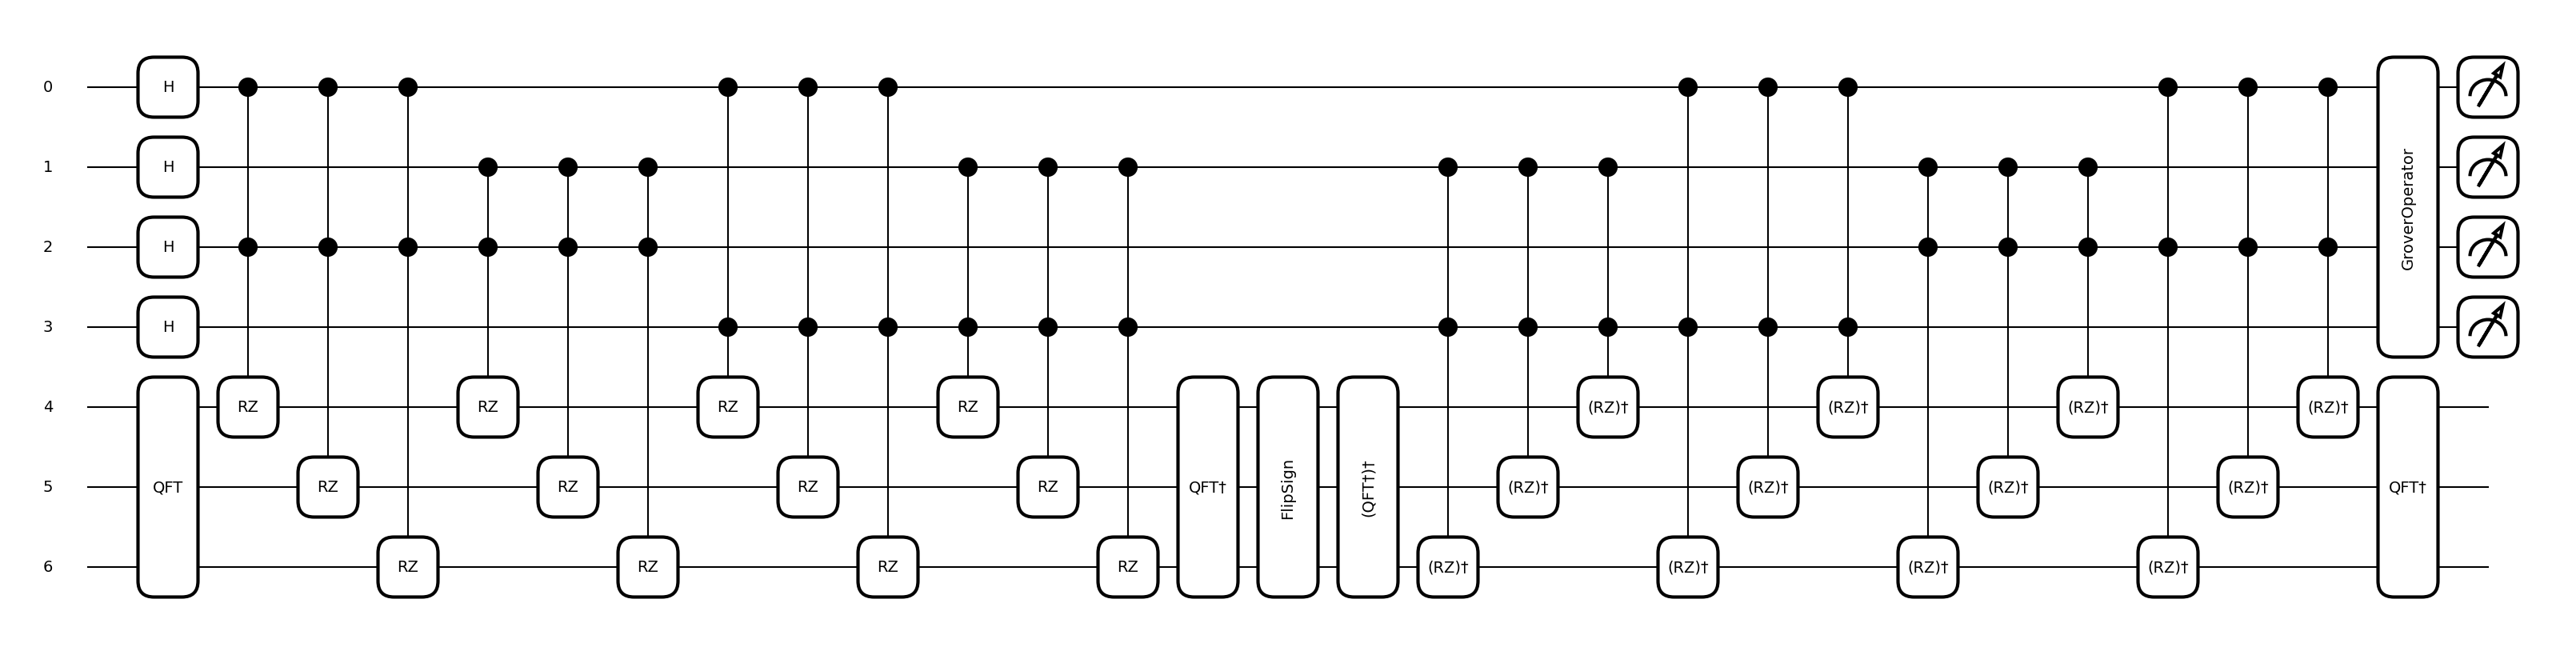

In [5]:
# draw circuit:
_ = qml.draw_mpl(FactorizationCircuit, style="black_white")(params)

We execute and measure the circuit on the Dynex platform:

In [7]:
probs = dynex_circuit.execute(FactorizationCircuit, params, wires, method='probs', num_reads=10000, 
                            integration_steps=1024, mainnet=True, shots=10)

╭────────────┬──────────┬─────────────────┬─────────────┬───────────┬────────────────┬────────────┬─────────┬────────────────╮
│   DYNEXJOB │   QUBITS │   QUANTUM GATES │   BLOCK FEE │   ELAPSED │   WORKERS READ │   CIRCUITS │   STEPS │   GROUND STATE │
├────────────┼──────────┼─────────────────┼─────────────┼───────────┼────────────────┼────────────┼─────────┼────────────────┤
│      29848 │       82 │             412 │        0.00 │      1.54 │             10 │     100000 │    1024 │      494636.00 │
╰────────────┴──────────┴─────────────────┴─────────────┴───────────┴────────────────┴────────────┴─────────┴────────────────╯
╭────────────┬─────────────────┬────────────┬───────┬──────────┬────────────────┬─────────────────────────────┬───────────┬──────────╮
│     WORKER │         VERSION │   CIRCUITS │   LOC │   ENERGY │        RUNTIME │                 LAST UPDATE │     STEPS │   STATUS │
├────────────┼─────────────────┼────────────┼───────┼──────────┼────────────────┼──────────────

In [8]:
threshold = 0.2 # This needs to be adjusted based on the qubits/n/iterations
p = ''.join(['1' if probs[i] > threshold else '0' for i in wires_p])
q = ''.join(['1' if probs[i] > threshold else '0' for i in wires_q])
p_digit = int(p, 2)
q_digit = int(q, 2)
state = p +"----"+ q
print(f">>> STATE: {state} :::: P:{p_digit} -- Q:{q_digit} <<<")

>>> STATE: 11----10 :::: P:3 -- Q:2 <<<
